In [1]:
import pandas as pd
import datetime
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from random import randint as rn
import numpy as np
from sklearn.metrics import r2_score

### Підготовча частина

Завантаження пдіготовленої таблиці даних

In [2]:
df = pd.read_pickle('data.pickle')
y_true = df.Value.copy()

In [3]:
df

,Time,Value
0,05:30:00,13.0
1,05:40:00,24.0
2,05:50:00,44.0
3,06:00:00,68.0
4,06:10:00,58.0
...,...,...
68,16:50:00,54.0
69,17:00:00,46.0
70,17:10:00,40.0
71,17:20:00,29.0


Відображення даних графічно з використанням Seaborn

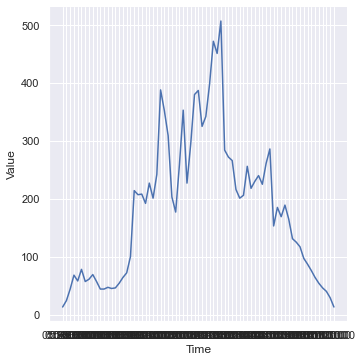

In [4]:
sns.set_theme(style="darkgrid")
sns.relplot(data=df, x='Time', y='Value', kind='line')

Видалення випадковим чином заданого відсотка значень

In [5]:
def make_nan(df, share=0.2):
    for i in range(int(np.ceil(len(df) * 0.2))):
        position = rn(0, len(df) - 1)
        df.at[position, 'Value'] = np.nan
    return df

df_nan = make_nan(df, share=0.2)

Перевірка кількості видалених значень у датасеті

In [6]:
df_nan.isna().sum().loc[df_nan.isna().sum() > 0].sort_values(ascending=True)

Value    14
dtype: int64

### Інтерполяція найближчим сусідом (сусідами)

Значення часового ряду, що розглядається, знаходяться на рівних часових інтервалах одне від одного.
Створюємо класс _NeighbourImputer_, який дозволить вставляти значення методом найближчого сусіда. З оглядом на рівні інтервали, метод вставляє правого сусіда, лівого сусіда або середня арифметичне двох сусідів. Метод вказується при ініціалізації інтервала класу.

In [7]:
class NeighbourImputer:
    
    def __init__(self, action='mean'):
        self.X = None
        self.res = None
        self.action = action
    
    def fit_transform(self, X):
        self.X = np.array(X)
        self.res = np.array(X)
        for n, x in enumerate(self.X):
            if np.isnan(x):
                n_minus = self.neighbour(n, up=False)
                n_plus = self.neighbour(n, up=True)
                if (not np.isnan(n_minus)) & (not np.isnan(n_plus)):
                    if self.action == 'mean':
                        self.res[n] = 1/2 * (n_minus + n_plus)
                    elif self.action == 'left':
                        self.res[n] = n_minus
                    elif self.action == 'right':
                        self.res[n] = n_plus
                elif not np.isnan(n_minus):
                    self.res[n] = n_minus
                elif not np.isnan(n_plus):
                    self.res[n] = n_plus
            
        return self.res
    
    def neighbour(self, n, up=True):
        if up:
            while np.isnan(self.X[n]):
                if n + 1 < len(self.X):
                    n += 1
                else:
                    return np.nan
            return self.X[n]
        else:
            while np.isnan(self.X[n]):
                if n - 1 > - 1:
                    n -= 1
                else:
                    return np.nan
            return self.X[n]                   

Проводимо відновлення значень

In [8]:
ni = NeighbourImputer(action='mean')
y_pred = ni.fit_transform(df_nan.Value)
df['NI_imputed'] = y_pred

In [9]:
print('Коефіцієнт детермінації = {}'.format(r2_score(y_true, y_pred)))

Коефіцієнт детермінації = 0.9726146486593685


Визначимо залежність коефіцієнту детермінації від частки видалених та відновленних значень

In [10]:
sharea, r2_a = [], []
for s in range(1, 9):
    share = 0.1 * s
    df_nan = make_nan(df, share=share)
    y_pred = ni.fit_transform(df_nan.Value)
    sharea.append(share)
    r2_a.append(r2_score(y_true, y_pred))

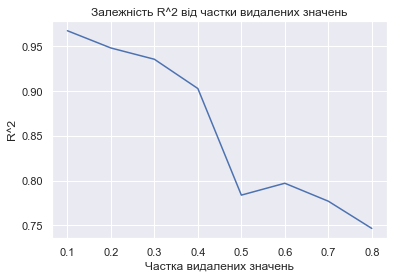

In [11]:
plt.plot(sharea, r2_a)
plt.title('Залежність R^2 від частки видалених значень')
plt.xlabel('Частка видалених значень')
plt.ylabel('R^2')
plt.show()

Для уточнення результатів моделювання треба провести визначення R^2 в ітераційному циклі та обрати середнє значення ряду в якості ітогового коефіцієнту.